In [1]:
!pip install -q -r requirements.txt

In [2]:
# !pip uninstall -y opencv-python-headless
# !pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


## Data Loading

In [1]:
from os.path import join
import numpy as np 
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_ROOT="./data/"

MRI_root_dir=join(DATA_ROOT,"MRI","MRI_Label")
MRI_anno_file=join(DATA_ROOT,"MRI","annotations/MRI_Label/annotations.json")

CT_root_dir=join(DATA_ROOT,"CT")
CT_anno_file=join(DATA_ROOT,"CT","annotations/annotations.json")

In [3]:
from dataloaders.ctmri_multiclass import CTMRI_MultiClassDataset
import albumentations as A
WIDTH, HEIGHT=256,256

class DivMax(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
    def apply(self, img, **params):
        img=img/np.max(img)
#         img[img<0.25]=0
#         img[img>0.65]=0
        return img
    
transform = A.Compose([
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
  A.Rotate((-30, 30), interpolation=0), 
  A.RandomContrast(limit=0.2, p=1),   
])

test_transform = A.Compose([           
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
])

In [4]:
ds_kwargs=dict(
    transform=transform,
    test_transform=test_transform,
    test_split=0.2
    )
MRI_ds=CTMRI_MultiClassDataset(MRI_anno_file,MRI_root_dir,**ds_kwargs)
CT_ds=CTMRI_MultiClassDataset(CT_anno_file,CT_root_dir,**ds_kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
import torch.utils.data as tud
ldr_kwargs=dict(
    batch_size=8,
    shuffle=True,
    pin_memory=False,
    num_workers=2
)
CT_loader=tud.DataLoader(CT_ds,**ldr_kwargs)
MRI_loader=tud.DataLoader(MRI_ds,**ldr_kwargs)

In [6]:
from dataloaders.ctmri_multiclass import occr_in_ds

MRI_occr=occr_in_ds(MRI_ds)
CT_occr=occr_in_ds(CT_ds)

BATCHSIZE= 3
(3, 256, 256, 3) 
 (3, 256, 256)


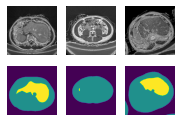

In [7]:
from utils.plotting import show_image_annot
CT_ds.training=True
x,y=next(iter(CT_loader))
show_image_annot(x.numpy().transpose(0,2,3,1),y.numpy(),showPics=3, vmax=CT_ds.n_cats)

In [8]:
set(y.flatten().numpy())

{0, 1, 2}

In [9]:
# from torch import nn

from models.backbone import UNet
from models.head import MetricLayer
from models.models import SegModel
backbone=UNet(decoder_chs=(512, 256, 128)).cuda()
latent_dims=128
head_ct=MetricLayer(n_in_features=latent_dims,n_out_features=1+CT_ds.n_cats).cuda()
model_ct=SegModel(backbone,head_ct,(WIDTH, HEIGHT)).cuda()

In [88]:
# from torchsummary import summary
# summary(backbone.encoder, (3, 224, 224))

In [10]:
def calc_acc(pred, y):
    correct=(pred.argmax(1)==y).flatten()
    return torch.sum(correct)/len(correct)
def one_batch(i_iter,log,sample_batched,model,criterion,optimizer):
    # Prep input
    x,y=[_.cuda() for _ in sample_batched]
    pred=model(x)
    loss = criterion(pred, y)
    if model.training:
        #Update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        acc=calc_acc(pred, y).item()
        if i_iter==0:
            log['acc'] = acc
        else:
            log['acc'] = (acc+log['acc']*i_iter)/(i_iter + 1)
    # Record
    loss_rec = loss.item()
    log['loss'] = (loss_rec+log['loss']*i_iter)/(i_iter + 1)
    return pred,loss

In [13]:
!mkdir snapshots

mkdir: cannot create directory ‘snapshots’: File exists


In [11]:
from losses.marginal import AddMarginLoss
w=1/torch.tensor(CT_occr,dtype=torch.float32).cuda()
criterion_ct = AddMarginLoss(ways=1+CT_ds.n_cats,s=10 ,m=1.4,weight=w)
optimizer_ct = torch.optim.SGD(model_ct.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# 
# scheduler = MultiStepLR(optimizer, milestones=[100, 200, 300], gamma=0.1)
# 

In [12]:
from tqdm import tqdm

EPOCH=100
model_ct.train()
best_loss=np.inf
PAITIENCE=5
count=0
try:
    for e in range(EPOCH):
        log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
        model_ct.train()
        CT_ds.training=True
        session=tqdm(enumerate(CT_loader))
        for i_iter, sample_batched in session:
            pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
            # print loss and take snapshots
            if (i_iter + 1) % 5 == 0:
                log['step']=i_iter+1
                session.set_postfix(log)
        # validate
        if (e + 1) % 2 == 0:
            log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
            model_ct.eval()
            CT_ds.training=False
            session=tqdm(enumerate(CT_loader))
            with torch.no_grad():
                for i_iter,sample_batched in session:
                    pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
                    if (i_iter + 1) % 5 == 0:
                        session.set_postfix(log)
            # early stop        
            if log["loss"]<best_loss:
                best_loss=log["loss"]
                torch.save(model_ct.state_dict(), 'snapshots/unet_arc_best.pth')
            elif count<=PAITIENCE: count+=1
            else:
                count=0
                best_loss=np.inf
                break 
            
except KeyboardInterrupt:
    print("\nHuman Interrupted")
torch.save(model_ct.state_dict(), 'snapshots/unet_arc_latest.pth')

288it [01:08,  4.17it/s, epoch=0, step=285, loss=3.86, acc=0.929]
288it [01:09,  4.13it/s, epoch=1, step=285, loss=1.79, acc=0.977]
72it [00:07,  9.99it/s, epoch=1, step=val, loss=1.6, acc=0.982] 
288it [01:09,  4.12it/s, epoch=2, step=285, loss=1.61, acc=0.982]
288it [01:10,  4.11it/s, epoch=3, step=285, loss=1.53, acc=0.985]
72it [00:07,  9.94it/s, epoch=3, step=val, loss=1.45, acc=0.988]
288it [01:10,  4.11it/s, epoch=4, step=285, loss=1.49, acc=0.987]
288it [01:10,  4.11it/s, epoch=5, step=285, loss=1.47, acc=0.988]
72it [00:07,  9.61it/s, epoch=5, step=val, loss=1.4, acc=0.989] 
288it [01:10,  4.11it/s, epoch=6, step=285, loss=1.44, acc=0.989]
288it [01:10,  4.11it/s, epoch=7, step=285, loss=1.43, acc=0.989]
72it [00:07,  9.93it/s, epoch=7, step=val, loss=1.38, acc=0.99]
288it [01:10,  4.11it/s, epoch=8, step=285, loss=1.42, acc=0.989]
288it [01:10,  4.11it/s, epoch=9, step=285, loss=1.42, acc=0.99] 
72it [00:07, 10.01it/s, epoch=9, step=val, loss=1.36, acc=0.991]
288it [01:09,  4


Human Interrupted


BATCHSIZE= 3
(3, 256, 256) 
 (3, 256, 256)


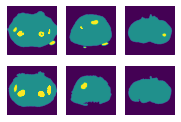

In [18]:
show_image_annot(pred.cpu().detach().argmax(1).numpy(),
                 sample_batched[1].cpu().detach().numpy(),
                 showPics=3, vmax=CT_ds.n_cats)

In [14]:
backbone.eval()
backbone.encoder.train()
backbone.requires_grad_(True)
# backbone.requires_grad_(False)
# for layer_id,p in enumerate(backbone.parameters()):
#     if layer_id <2:
#         p.requires_grad=True
        
#     else:
#         break
mri_head=MetricLayer(n_in_features=latent_dims,n_out_features=1+MRI_ds.n_cats).cuda()
model_mri=SegModel(backbone,mri_head,(WIDTH, HEIGHT)).cuda()

w=1/torch.tensor(MRI_occr,dtype=torch.float32).cuda()
criterion_mri = AddMarginLoss(ways=1+MRI_ds.n_cats,s=10 ,m=1.4,weight=w)
optimizer_mri = torch.optim.SGD(model_mri.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)

In [15]:
from tqdm import tqdm

EPOCH=300
model_mri.train()
best_loss=np.inf
PAITIENCE=5
count=0
try:
    for e in range(EPOCH):
        log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
        model_mri.train()
        MRI_ds.training=True
        session=tqdm(enumerate(MRI_loader))
        for i_iter, sample_batched in session:
            pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
            # print loss and take snapshots
            if (i_iter + 1) % 5 == 0:
                log['step']=i_iter+1
                session.set_postfix(log)
        # validate
        if (e + 1) % 2 == 0:
            log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
            model_mri.eval()
            MRI_ds.training=False
            session=tqdm(enumerate(MRI_loader))
            with torch.no_grad():
                for i_iter,sample_batched in session:
                    pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
                    session.set_postfix(log)
                        
            # early stop        
            if log["loss"]<best_loss:
                best_loss=log["loss"]
                torch.save(model_mri.state_dict(), 'snapshots/unet_arc_mri_best.pth')
            elif count<=PAITIENCE: count+=1
            else:
                count=0
                best_loss=np.inf
                break 
            
except KeyboardInterrupt:
    print("\nHuman Interrupted")
torch.save(model_mri.state_dict(), 'snapshots/unet_arc_mri_latest.pth')

16it [00:04,  3.80it/s, epoch=0, step=15, loss=13.9, acc=0.517]
16it [00:04,  3.79it/s, epoch=1, step=15, loss=10.1, acc=0.871]
4it [00:00,  6.68it/s, epoch=1, step=val, loss=8.82, acc=0.905]
16it [00:04,  3.78it/s, epoch=2, step=15, loss=8.65, acc=0.905]
16it [00:04,  3.78it/s, epoch=3, step=15, loss=7.74, acc=0.91] 
4it [00:00,  6.90it/s, epoch=3, step=val, loss=7, acc=0.925]   
16it [00:04,  3.78it/s, epoch=4, step=15, loss=7.25, acc=0.912]
16it [00:04,  3.78it/s, epoch=5, step=15, loss=6.71, acc=0.913]
4it [00:00,  7.05it/s, epoch=5, step=val, loss=6.01, acc=0.926]
16it [00:04,  3.81it/s, epoch=6, step=15, loss=6.4, acc=0.913] 
16it [00:04,  3.79it/s, epoch=7, step=15, loss=5.99, acc=0.915]
4it [00:00,  6.74it/s, epoch=7, step=val, loss=5.55, acc=0.934]
16it [00:04,  3.76it/s, epoch=8, step=15, loss=5.81, acc=0.924]
16it [00:04,  3.80it/s, epoch=9, step=15, loss=5.64, acc=0.927]
4it [00:00,  6.96it/s, epoch=9, step=val, loss=5.3, acc=0.933] 
16it [00:04,  3.79it/s, epoch=10, step=1

In [26]:
model_mri.eval()
MRI_ds.training=False
session=tqdm(enumerate(MRI_loader))
with torch.no_grad():
    for i_iter,sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
        session.set_postfix(log)
        break

0it [00:00, ?it/s, epoch=47, step=val, loss=2.93, acc=0.959]


BATCHSIZE= 8
(8, 256, 256) 
 (8, 256, 256)


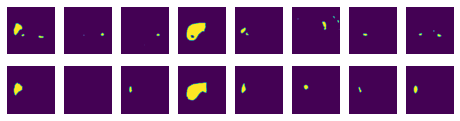

In [31]:
show_image_annot((pred.cpu().detach()[:,2]>=0.3).numpy(),
                 (sample_batched[1]==2).cpu().detach().numpy(),
                 showPics=8, vmax=1)

In [95]:
set(sample_batched[1].flatten().numpy())

{0, 1, 2, 3, 4, 5}

In [42]:
# from dataloaders.ctmri_multiclass import CTMRI_InferenceDataset
from pycocotools.coco import COCO
from pydicom import dcmread
def load_dcm(fname):
    ds=dcmread(fname).pixel_array
    # 調整格式以配合albumentation套件需求
    return ds.astype('uint8')
class CTMRI_InferenceDataset(tud.Dataset):
    def __init__(self,anno_file,
                 root_dir,
                 test_transform=None):
        
        self.root_dir=root_dir
        self.test_transform=test_transform
        self.coco_obj=COCO(anno_file)
        self.element=self.coco_obj.imgs
        self.n_cats=len(self.coco_obj.cats)
        self.cat_ids=list(self.coco_obj.cats.keys())
    def __len__(self) -> int:
        return len(self.element)
    def __getitem__(self,id):
        img_obj=self.element[id]
        transform=self.test_transform
        # Read dcm to image
        image = load_dcm(join(self.root_dir,img_obj['file_name']))
        # Albumentation
        if transform:
            transformed = transform(image=image)
            image= transformed['image']
        # Image preparation    
        image = image[np.newaxis,...].repeat(3,axis=0)
        return image

In [61]:
ldr_kwargs=dict(
    batch_size=8,
    shuffle=False,
    pin_memory=False,
    num_workers=2
)
test_root_dir=join(DATA_ROOT,"testset")
test_anno_file=join(DATA_ROOT,"testset","annotations/annotations.json")
test_ds=CTMRI_InferenceDataset(test_anno_file,test_root_dir,test_transform=test_transform)
MRI_loader=tud.DataLoader(test_ds,**ldr_kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [69]:
model_mri.eval()
pred=[]
with torch.no_grad():
    for xx in MRI_loader:
        pred.append(model_mri(xx.cuda()))
pred=torch.cat(pred)

In [70]:
pred.shape

torch.Size([160, 6, 256, 256])

In [73]:
predictions=pred.cpu().detach().numpy()

In [75]:
np.savez("prediction.npz",predictions)

In [ ]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
# output=[*map(mask2rle,(pred.argmax(1)==2).astype("int8"))]
output=[*map(mask2rle,(predictions[:,2]>0.55).astype("int8"))]